In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


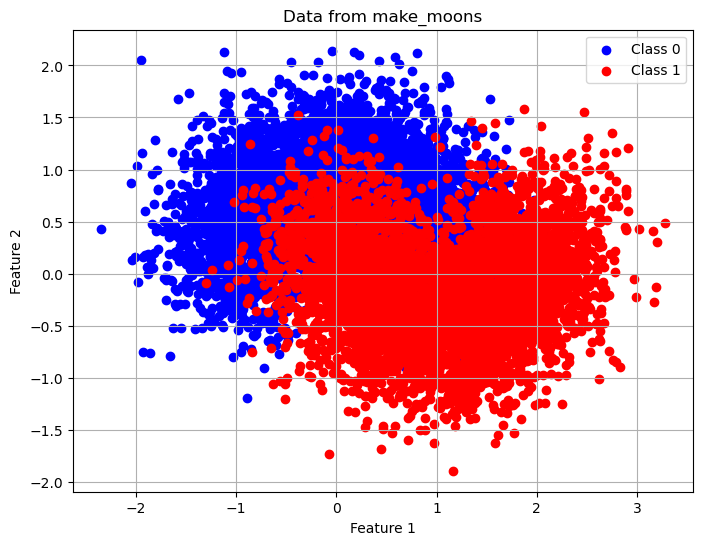

In [3]:
import matplotlib.pyplot as plt

class_0 = X[y == 0]
class_1 = X[y == 1]

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(class_0[:, 0], class_0[:, 1], c='b', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], c='r', label='Class 1')
plt.title('Data from make_moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

tree_clf = DecisionTreeClassifier()

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.80839895, 0.80164979, 0.8072018 ])

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [4, 6, 8, 10, 13],  # You can adjust the values based on your dataset size and complexity
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.0, 0.001, 0.01]
}

grid_search = GridSearchCV(tree_clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.001, 0.01],
                         'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 13],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_impurity_decrease': [0.0, 0.1, 0.2],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [7]:
grid_search.best_params_

{'ccp_alpha': 0.001,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'splitter': 'best'}

In [8]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred) #will go to 82% on whole dataset

0.8215

In [9]:
from sklearn.model_selection import ShuffleSplit

model = DecisionTreeClassifier(ccp_alpha=0.0, 
                               class_weight=None, 
                               criterion='gini', 
                               max_depth=6, 
                               max_features='sqrt', 
                               max_leaf_nodes=20, 
                               min_impurity_decrease=0.0, 
                               min_samples_leaf=1, 
                               min_samples_split=10, 
                               splitter='best')

shuffle_split = ShuffleSplit(n_splits=1000, train_size=0.01)
mean = 0

for train_index, test_index in shuffle_split.split(X, y):
    X_train_shuffle, X_test = X[train_index], X[test_index]
    y_train_shuffle, y_test = y[train_index], y[test_index]

    # Train the Decision Tree on the training data
    model.fit(X_train_shuffle, y_train_shuffle)

    # Evaluate the Decision Tree on the test data (optional)
    accuracy = model.score(X_test, y_test)
    mean += accuracy
print(mean / 1000)

0.7990775757575759


In [10]:
from scipy.stats import mode
from sklearn.base import clone

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.797220707070707

In [11]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [12]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [13]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8670707070707071